# Temporal Dynamics of Campus Placement Ecosystems: A Multi-Dimensional Visual Analytics Framework

### By:
### Nehan Ahmad - PES1UG23AM184
### Prateek P - PES1UG23AM211
### Noel Jose - PES1UG23AM197

In [1]:
# Install required packages if not present
# !pip install pandas numpy matplotlib seaborn plotly scipy scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import json
import re
import warnings
from pathlib import Path
from typing import Dict, List, Optional
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from IPython.display import display, HTML, Markdown

# Configuration
warnings.filterwarnings('ignore')
plt.rcParams['figure.facecolor'] = 'white'
pd.set_option('display.max_columns', None)

# Create output directory
Path("processed_data").mkdir(exist_ok=True)

print("✅ Environment Setup Complete")

✅ Environment Setup Complete


## Data Consolidation Module

In [2]:
class PlacementDataConsolidator:
    """Consolidates placement data from various sources into unified format."""

    def __init__(self, data_dir: str = "data", output_dir: str = "processed_data"):
        self.data_dir = Path(data_dir)
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(exist_ok=True)

    def clean_numeric(self, value: any) -> Optional[float]:
        if pd.isna(value) or value == '': return None
        if not isinstance(value, str):
            try: return float(value)
            except: return None
        value = str(value).strip()
        if value == '' or value.lower() in ['na', 'nan', 'n/a', '-', 'nil', '.']: return None
        value = re.sub(r'[₹$,\s]', '', value)
        value = re.sub(r'(?i)(lpa|lakh|lakhs|k|per month)', '', value)
        if '-' in value or '–' in value:
            parts = re.split(r'[-–]', value)
            try:
                nums = [float(re.sub(r'[^\d.]', '', p)) for p in parts if re.search(r'\d', p)]
                if nums: return max(nums)
            except: pass
        match = re.search(r'(\d+\.?\d*)', value)
        if match:
            try: return float(match.group(1))
            except: return None
        return None

    def clean_company_name(self, name: str) -> str:
        if pd.isna(name) or name == '': return 'Unknown'
        name = str(name).strip()
        name = re.sub(r'\s+', ' ', name)
        name = name.title()
        replacements = {'Ibm': 'IBM', 'Hp ': 'HP ', 'Hpe': 'HPE', 'Sap': 'SAP', 'Ey ': 'EY ',
                        'Ai': 'AI', 'Aws': 'AWS', 'Gcp': 'GCP', 'Iot': 'IoT', 'Kpmg': 'KPMG',
                        'Pwc': 'PwC', 'Jpmc': 'JPMC', 'Jpmorgan': 'JPMorgan'}
        for old, new in replacements.items():
            name = re.sub(r'\b' + old + r'\b', new, name, flags=re.IGNORECASE)
        return name

    def extract_tier_from_filename(self, filename: str) -> str:
        filename_lower = filename.lower()
        if 'dream' in filename_lower: return 'Dream'
        elif 'tier 1' in filename_lower or 'tier-1' in filename_lower or 'tier1' in filename_lower: return 'Tier-1'
        elif 'tier 2' in filename_lower or 'tier-2' in filename_lower or 'tier2' in filename_lower: return 'Tier-2'
        elif 'tier 3' in filename_lower or 'tier-3' in filename_lower or 'tier3' in filename_lower: return 'Tier-3'
        elif 'spring' in filename_lower: return 'Internship-Spring'
        elif 'summer' in filename_lower: return 'Internship-Summer'
        elif 'internship' in filename_lower: return 'Internship'
        return 'Unknown'

    def is_likely_row_number(self, value: str) -> bool:
        val_str = str(value).strip()
        if re.match(r'^\d+\.?0*$', val_str): return True
        if val_str in ['#', 'No', 'S.No', 'Sr.No']: return True
        return False

    def process_file(self, filepath: Path, batch_year: int) -> pd.DataFrame:
        try:
            df = pd.read_csv(filepath)
            header_row = 0
            for i in range(min(5, len(df))):
                row_str = ' '.join([str(x).lower() for x in df.iloc[i].values])
                if 'company' in row_str or 'name' in row_str:
                    header_row = i
                    break
            if header_row > 0:
                df = pd.read_csv(filepath, skiprows=header_row)
        except Exception as e:
            print(f"    ✗ Could not read file: {e}")
            return pd.DataFrame()

        tier = self.extract_tier_from_filename(filepath.name)
        records = []

        for idx, row in df.iterrows():
            company_name = None
            company_col_idx = None
            for i in range(min(4, len(row))):
                val = str(row.iloc[i]).strip()
                if val and val not in ['', 'nan']:
                    if self.is_likely_row_number(val): continue
                    if val.lower() in ['company', 'name', 'company name', 'job title', 'job role']: continue
                    company_name = val
                    company_col_idx = i
                    break
            
            if not company_name or company_name == 'nan': continue
            company_name = self.clean_company_name(company_name)
            if company_name == 'Unknown': continue
            if company_name.lower() in ['internship', 'base', 'compensation', 'ctc', 'placed', 'fte', 'intern', 'job title', 'job role', 'company name', 'remarks', 'cgpa', 'cut-off', 'cutoff', 'sde', 'sdet', 'engineer', 'analyst', 'developer', 'trainee']:
                continue

            job_role = ''
            if company_col_idx is not None and company_col_idx + 1 < len(row):
                jr = str(row.iloc[company_col_idx + 1]).strip()
                if jr and jr not in ['', 'nan'] and not jr.replace('.', '').isdigit():
                    job_role = jr

            start_col = (company_col_idx or 1) + 2
            row_data = [self.clean_numeric(x) for x in row.iloc[start_col:start_col+10]]

            record = {
                'batch_year': batch_year, 'company_name': company_name, 'job_role': job_role, 'tier': tier,
                'internship_stipend_monthly': row_data[0] if len(row_data) > 0 else None,
                'base_salary': row_data[1] if len(row_data) > 1 else None,
                'total_ctc': row_data[2] if len(row_data) > 2 else None,
                'num_fte': row_data[3] if len(row_data) > 3 else None,
                'num_intern': row_data[4] if len(row_data) > 4 else None,
                'num_fte_intern': row_data[5] if len(row_data) > 5 else None,
                'cgpa_cutoff': row_data[6] if len(row_data) > 6 else None,
            }
            records.append(record)
        return pd.DataFrame(records)

    def run(self):
        print("🔄 Starting Data Consolidation...")
        all_records = []
        # Looking for years 2022-2026 in the data_dir
        for year in [2022, 2023, 2024, 2025, 2026]:
            year_dir = self.data_dir / str(year)
            if not year_dir.exists(): continue
            
            print(f"  📂 Processing {year}...")
            csv_files = list(year_dir.glob("*.csv"))
            for filepath in csv_files:
                try:
                    df = self.process_file(filepath, year)
                    if len(df) > 0: all_records.append(df)
                except Exception as e: print(f"    ✗ Error {filepath.name}: {e}")

        if not all_records:
            print("⚠️ No data found. Please check 'data/' folder structure.")
            return pd.DataFrame()

        df = pd.concat(all_records, ignore_index=True)
        
        # Cleaning
        df = df.dropna(how='all')
        df = df[df['company_name'].notna() & (df['company_name'] != 'Unknown')]
        numeric_cols = ['internship_stipend_monthly', 'base_salary', 'total_ctc', 'num_fte', 'num_intern', 'num_fte_intern', 'cgpa_cutoff']
        for col in numeric_cols: df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Logic fixes
        mask = df['total_ctc'].isna() & df['base_salary'].notna()
        df.loc[mask, 'total_ctc'] = df.loc[mask, 'base_salary']
        is_internship = df['tier'].str.contains('Internship', case=False, na=False)
        df.loc[is_internship & (df['total_ctc'] > 0) & (df['total_ctc'] < 2), 'total_ctc'] = df.loc[is_internship & (df['total_ctc'] > 0) & (df['total_ctc'] < 2), 'total_ctc'] * 12
        df.loc[df['total_ctc'] <= 0, 'total_ctc'] = None
        df.loc[df['total_ctc'] > 250, 'total_ctc'] = None
        df.loc[(df['cgpa_cutoff'] < 0) | (df['cgpa_cutoff'] > 10), 'cgpa_cutoff'] = None
        
        df['is_internship'] = is_internship
        df['has_ctc_data'] = df['total_ctc'].notna()
        df['has_cgpa_data'] = df['cgpa_cutoff'].notna()

        # Save
        output_path = self.output_dir / 'placement_data.csv'
        df.to_csv(output_path, index=False)
        print(f"✅ Saved consolidated data to {output_path} ({len(df)} records)")
        return df

# Execution
consolidator = PlacementDataConsolidator()
df_master = consolidator.run()
display(df_master.head())

🔄 Starting Data Consolidation...
  📂 Processing 2022...
  📂 Processing 2023...
  📂 Processing 2024...
  📂 Processing 2025...
  📂 Processing 2026...
✅ Saved consolidated data to processed_data\placement_data.csv (1902 records)


,batch_year,company_name,job_role,tier,internship_stipend_monthly,base_salary,total_ctc,num_fte,num_intern,num_fte_intern,cgpa_cutoff,is_internship,has_ctc_data,has_cgpa_data
0,2022,Internship Stipend,Base,Dream,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
1,2022,Apple India,Software Engineer,Dream,NaN,16.0,65.0,NaN,5.0,NaN,NaN,False,True,False
2,2022,Eightfold.AI,Business Analyst,Dream,NaN,25.0,60.5,NaN,NaN,NaN,NaN,False,True,False
3,2022,Stipend,Interns,Internship-Spring,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False
4,2022,American Express,Technology Intern,Internship-Spring,70.0,NaN,21.0,21.0,21.0,NaN,NaN,True,True,False


## Temporal Analysis & Prediction Logic

In [3]:
class TemporalAnalyzer:
    def __init__(self, data_path: str = "processed_data/placement_data.csv"):
        self.df = pd.read_csv(data_path)
        self.df['batch_year'] = pd.to_numeric(self.df['batch_year'], errors='coerce')
        self.fte_df = self.df[~self.df['is_internship']].copy()
        self.intern_df = self.df[self.df['is_internship']].copy()

    def get_yearly_statistics(self) -> pd.DataFrame:
        yearly_stats = []
        for year in sorted(self.df['batch_year'].unique()):
            year_data = self.fte_df[self.fte_df['batch_year'] == year]
            year_data_ctc = year_data[year_data['has_ctc_data']]
            stats_dict = {
                'year': int(year),
                'total_placements': len(year_data),
                'mean_ctc': year_data_ctc['total_ctc'].mean() if len(year_data_ctc) > 0 else None,
                'median_ctc': year_data_ctc['total_ctc'].median() if len(year_data_ctc) > 0 else None,
                'std_ctc': year_data_ctc['total_ctc'].std() if len(year_data_ctc) > 0 else None,
            }
            yearly_stats.append(stats_dict)
        return pd.DataFrame(yearly_stats)

    def forecast_ctc_simple(self, forecast_years: int = 2) -> Dict:
        yearly_stats = self.get_yearly_statistics().dropna(subset=['mean_ctc'])
        if len(yearly_stats) < 2: return {"error": "Insufficient data"}

        X = yearly_stats['year'].values.reshape(-1, 1)
        y_mean = yearly_stats['mean_ctc'].values
        y_median = yearly_stats['median_ctc'].values

        model_mean = LinearRegression().fit(X, y_mean)
        model_median = LinearRegression().fit(X, y_median)

        last_year = int(yearly_stats['year'].max())
        future_years = np.array([last_year + i for i in range(1, forecast_years + 1)]).reshape(-1, 1)
        
        mean_preds = model_mean.predict(future_years)
        median_preds = model_median.predict(future_years)
        
        # Confidence interval approx
        residuals = y_mean - model_mean.predict(X)
        std_res = np.std(residuals)

        predictions = []
        for i, year in enumerate(future_years.flatten()):
            predictions.append({
                'year': int(year),
                'predicted_mean_ctc': float(mean_preds[i]),
                'predicted_median_ctc': float(median_preds[i]),
                'upper_bound': float(mean_preds[i] + 1.96 * std_res),
                'lower_bound': float(mean_preds[i] - 1.96 * std_res)
            })
        
        return {'predictions': predictions, 'r2_mean': r2_score(y_mean, model_mean.predict(X))}

    def generate_temporal_insights(self) -> Dict:
        yearly_stats = self.get_yearly_statistics()
        ctc_forecast = self.forecast_ctc_simple()
        
        insights = {
            'yearly_statistics': yearly_stats.to_dict('records'),
            'ctc_forecast': ctc_forecast
        }
        
        # Generate emerging companies
        all_years = sorted(self.fte_df['batch_year'].unique())
        if len(all_years) >= 2:
            recent_years = all_years[-2:]
            older_years = all_years[:-2]
            recent_cos = set(self.fte_df[self.fte_df['batch_year'].isin(recent_years)]['company_name'])
            older_cos = set(self.fte_df[self.fte_df['batch_year'].isin(older_years)]['company_name'])
            emerging = recent_cos - older_cos
            insights['emerging_count'] = len(emerging)
            insights['emerging_examples'] = list(emerging)[:10]
            
        return insights

# Run Analysis
analyzer = TemporalAnalyzer()
temporal_data = analyzer.generate_temporal_insights()
print("✅ Temporal Analysis Complete")
print(f"📊 R² Score for Prediction: {temporal_data['ctc_forecast'].get('r2_mean', 0):.4f}")
pd.DataFrame(temporal_data['ctc_forecast'].get('predictions', []))

✅ Temporal Analysis Complete
📊 R² Score for Prediction: 0.0441


,year,predicted_mean_ctc,predicted_median_ctc,upper_bound,lower_bound
0,2027,13.956135,11.975,17.810734,10.101535
1,2028,14.254879,12.450,18.109479,10.400280


## Interactive Plots

In [4]:
def render_dashboard(df, temporal_data):
    display(Markdown("# 🎓 PES Placement Analytics Dashboard"))
    
    # 1. Filter Logic (Simulated)
    df_fte = df[~df['is_internship'] & df['has_ctc_data']].copy()
    
    # 2. Key Metrics
    avg_ctc = df_fte['total_ctc'].mean()
    max_ctc = df_fte['total_ctc'].max()
    companies = df['company_name'].nunique()
    
    print(f"STATS: Avg FTE CTC: ₹{avg_ctc:.2f} LPA | Max CTC: ₹{max_ctc:.2f} LPA | Companies: {companies}")

    # 3. FTE CTC Distribution
    fig_dist = px.histogram(df_fte, x='total_ctc', nbins=40, 
                            title='FTE CTC Distribution', 
                            color_discrete_sequence=['#1f77b4'])
    fig_dist.show()

    # 4. Yearly CTC Trends
    yearly = df_fte.groupby('batch_year')['total_ctc'].agg(['mean', 'median']).reset_index()
    fig_trend = go.Figure()
    fig_trend.add_trace(go.Scatter(x=yearly['batch_year'], y=yearly['mean'], name='Mean CTC', line=dict(color='blue')))
    fig_trend.add_trace(go.Scatter(x=yearly['batch_year'], y=yearly['median'], name='Median CTC', line=dict(color='green')))
    
    # Add Forecast Lines
    if 'predictions' in temporal_data['ctc_forecast']:
        preds = temporal_data['ctc_forecast']['predictions']
        pred_years = [p['year'] for p in preds]
        pred_means = [p['predicted_mean_ctc'] for p in preds]
        
        # Connect last historical to first prediction
        all_years = list(yearly['batch_year']) + pred_years
        all_means = list(yearly['mean']) + pred_means
        
        fig_trend.add_trace(go.Scatter(x=all_years, y=all_means, name='Forecast', 
                                       line=dict(color='red', dash='dash')))

    fig_trend.update_layout(title='CTC Trends & Forecast', yaxis_title='CTC (LPA)')
    fig_trend.show()

    # 5. Top Recruiters
    top_rec = df['company_name'].value_counts().head(15)
    fig_rec = px.bar(x=top_rec.values, y=top_rec.index, orientation='h', 
                     title='Top 15 Recruiters by Volume', color=top_rec.values)
    fig_rec.show()

    # 6. CTC by Tier
    fig_box = px.box(df_fte, x='tier', y='total_ctc', color='tier', 
                     title='CTC Distribution by Tier')
    fig_box.show()

# Render
if 'df_master' in locals():
    render_dashboard(df_master, temporal_data)
else:
    print("⚠️ Run Cell 2 first to load data.")

# 🎓 PES Placement Analytics Dashboard

STATS: Avg FTE CTC: ₹12.61 LPA | Max CTC: ₹118.00 LPA | Companies: 1327


✅ Loaded detailed temporal data (225 records)


## 💰 The Money Trail: CTC Evolution

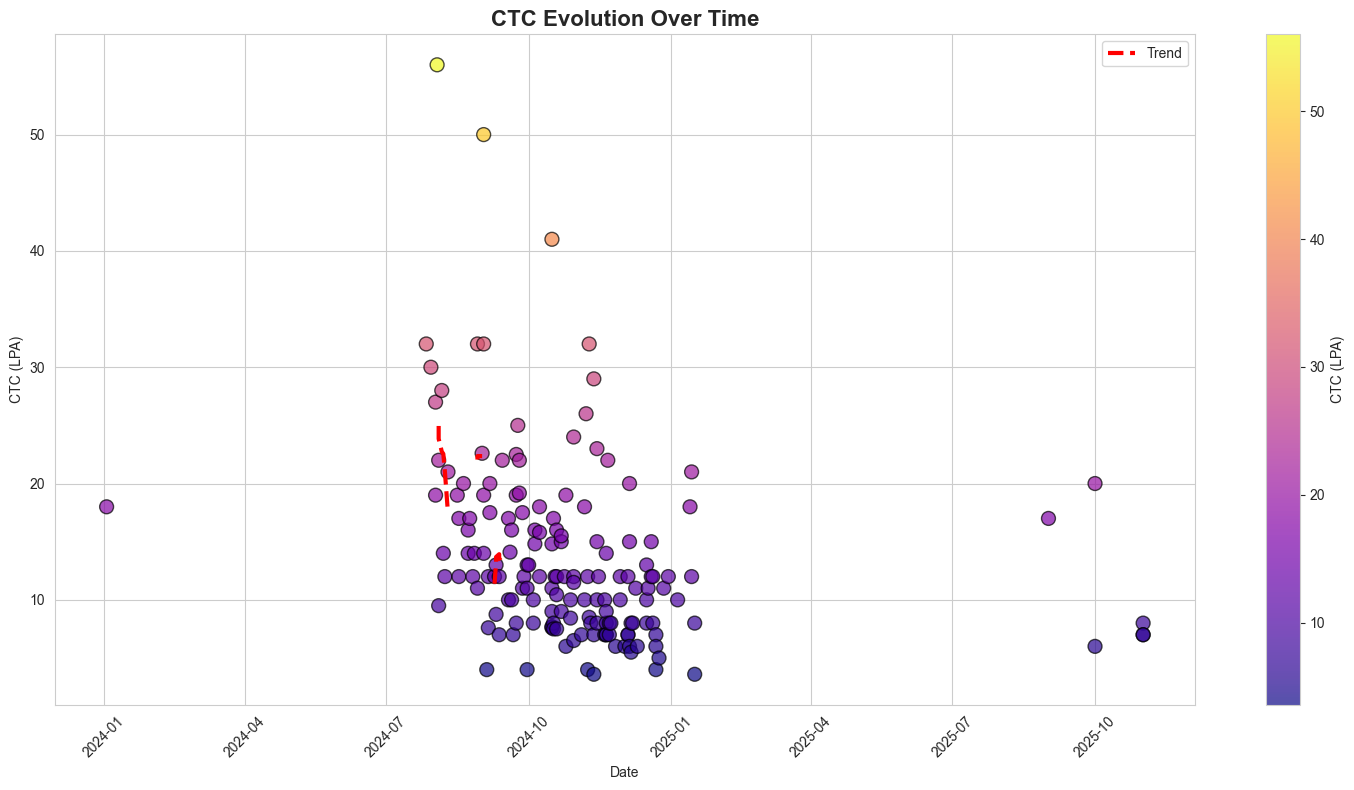

## 🎯 Multi-Dimensional Analysis

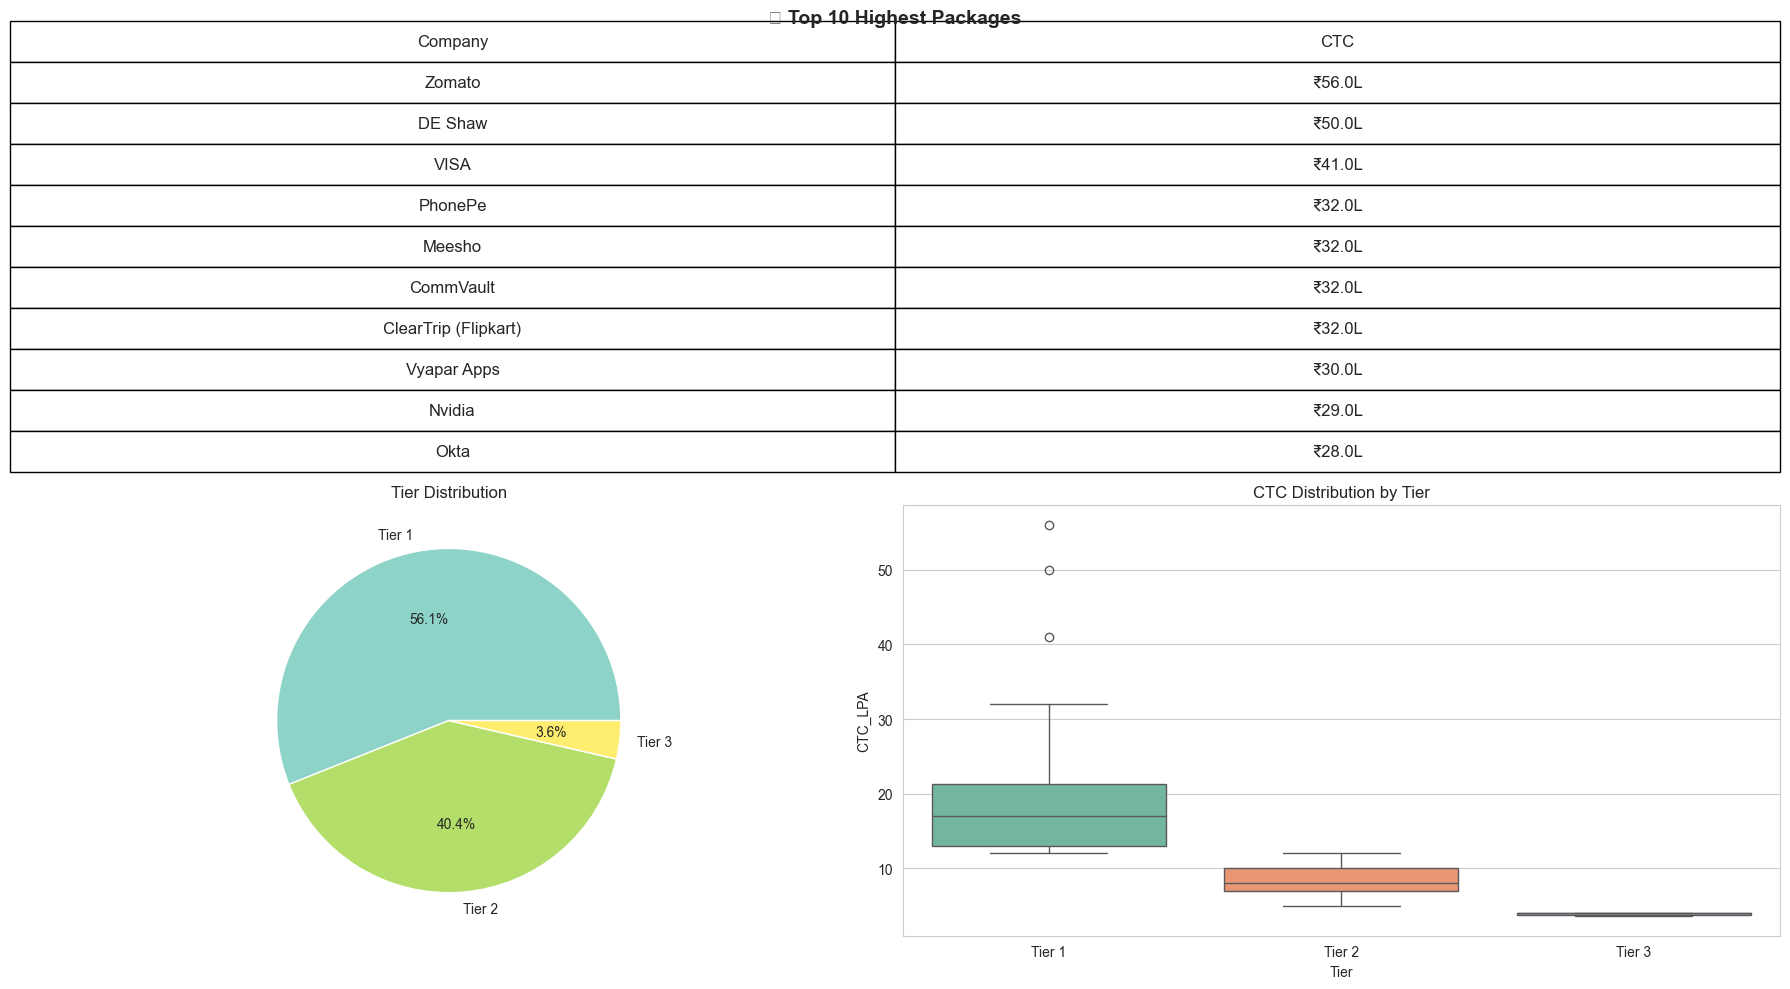

In [5]:
def generate_publication_plots():
    # Try to load the detailed dataset with dates
    try:
        df_detailed = pd.read_csv('processed_data/2025_PES_withTemporalData.csv')
        df_detailed['Date_OA'] = pd.to_datetime(df_detailed['Date_OA'], format='%d-%m-%Y', errors='coerce')
        df_valid = df_detailed.dropna(subset=['Date_OA']).sort_values('Date_OA')
        print(f"✅ Loaded detailed temporal data ({len(df_valid)} records)")
        has_dates = True
    except FileNotFoundError:
        print("⚠️ '2025_PES_withTemporalData.csv' not found. Using master data (Date plots will be skipped).")
        df_valid = df_master.copy()
        has_dates = False

    sns.set_style("whitegrid")
    
    # --- PLOT 1: CTC Evolution (Requires Dates) ---
    if has_dates:
        display(Markdown("## 💰 The Money Trail: CTC Evolution"))
        fig, ax = plt.subplots(figsize=(15, 8))
        
        sc = ax.scatter(df_valid['Date_OA'], df_valid['CTC_LPA'], 
                        c=df_valid['CTC_LPA'], cmap='plasma', s=100, alpha=0.7, edgecolors='k')
        
        # Moving Average
        df_valid['MA'] = df_valid['CTC_LPA'].rolling(window=10, center=True).mean()
        ax.plot(df_valid['Date_OA'], df_valid['MA'], color='red', lw=3, ls='--', label='Trend')
        
        plt.colorbar(sc, label='CTC (LPA)')
        plt.title('CTC Evolution Over Time', fontsize=16, fontweight='bold')
        plt.xlabel('Date')
        plt.ylabel('CTC (LPA)')
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()

    # --- PLOT 2: Multi-Dimensional Analysis (Works with Master Data) ---
    display(Markdown("## 🎯 Multi-Dimensional Analysis"))
    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(2, 2)

    # Top Companies Table
    ax1 = fig.add_subplot(gs[0, :])
    ax1.axis('off')
    
    # Prepare data for table
    col_ctc = 'CTC_LPA' if 'CTC_LPA' in df_valid.columns else 'total_ctc'
    col_comp = 'Company' if 'Company' in df_valid.columns else 'company_name'
    
    top_companies = df_valid.nlargest(10, col_ctc)[[col_comp, col_ctc]]
    table_data = [[row[col_comp], f"₹{row[col_ctc]}L"] for _, row in top_companies.iterrows()]
    
    table = ax1.table(cellText=table_data, colLabels=['Company', 'CTC'], 
                      loc='center', cellLoc='center')
    table.scale(1, 2)
    table.set_fontsize(12)
    ax1.set_title("🏆 Top 10 Highest Packages", fontweight='bold', fontsize=14)

    # Tier Pie Chart
    ax2 = fig.add_subplot(gs[1, 0])
    tier_col = 'Tier' if 'Tier' in df_valid.columns else 'tier'
    df_valid[tier_col].value_counts().plot.pie(autopct='%1.1f%%', ax=ax2, cmap='Set3')
    ax2.set_ylabel('')
    ax2.set_title("Tier Distribution")

    # CTC Box Plot
    ax3 = fig.add_subplot(gs[1, 1])
    sns.boxplot(data=df_valid, x=tier_col, y=col_ctc, ax=ax3, palette="Set2")
    ax3.set_title("CTC Distribution by Tier")

    plt.tight_layout()
    plt.show()

generate_publication_plots()